# Cerebrum Artis: Comprehensive System Demo (V3.1 Integrated)

Este notebook demonstra o funcionamento completo do sistema **Cerebrum Artis V3.1 (Integrated Fuzzy-Neural Gating)**.

**Funcionalidades demonstradas:**
1.  **Entrada Flexível**: Aceita Imagem + Legenda (Opcional). Se a legenda não for fornecida, o módulo **SAT (Show, Attend and Tell)** gera uma automaticamente.
2.  **Análise Multimodal**: Processa visual (ResNet50), textual (RoBERTa) e features artísticas (Fuzzy).
3.  **Transparência do Modelo**:
    *   Visualização das probabilidades da branch **Neural**.
    *   Visualização das probabilidades da branch **Fuzzy**.
    *   Cálculo do **Agreement** (Concordância) que regula o Gating Mechanism.
4.  **Explicabilidade (XAI)**:
    *   **Grad-CAM**: Mapa de calor mostrando onde o modelo "olhou".
    *   **Análise Textual**: Explicação do porquê da decisão.

---

In [11]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from transformers import RobertaTokenizer, RobertaModel
from torchvision import models, transforms
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Configuração de caminhos
PROJECT_ROOT = Path('/home/paloma/cerebrum-artis')
sys.path.insert(0, str(PROJECT_ROOT))
# Adiciona o caminho do fuzzy_brain
sys.path.insert(0, str(PROJECT_ROOT / 'cerebrum_artis/fuzzy'))

# Importa o FuzzyInferenceSystem
from fuzzy_brain.fuzzy.system import FuzzyInferenceSystem

# Importa o extrator LAB REAL
from fuzzy_brain.feature_extractor_lab import LABFeatureExtractor

# Importa SAT Loader SIMPLIFICADO
from fuzzy_brain.sat_loader_simple import SATModelLoader

# Importar ExplicadorVisual diretamente sem __init__.py
import importlib.util
spec = importlib.util.spec_from_file_location(
    "explicador_module",
    PROJECT_ROOT / "cerebrum_artis/agents/explicador.py"
)
explicador_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(explicador_module)
ExplicadorVisual = explicador_module.ExplicadorVisual

# Configuração de visualização
plt.style.use('seaborn-v0_8-paper')
sns.set_context("notebook", font_scale=1.2)

# Device (GPU 2 que está livre)
device = torch.device('cuda:2')
print(f"🚀 Running on {device}")

# Emoções ArtEmis
EMOTIONS = [
    'amusement', 'awe', 'contentment', 'excitement', 
    'anger', 'disgust', 'fear', 'sadness', 'something else'
]

print("✅ Imports concluídos com sucesso!")

🚀 Running on cuda:2
✅ Imports concluídos com sucesso!


In [12]:
# ============================================================================
# 1. DEFINIÇÃO DO MODELO V3.1 (Integrated Fuzzy-Neural Gating)
# ============================================================================
# Copiado de cerebrum_artis/models/v3_1_integrated/train_v3_1.py para garantir execução standalone

class IntegratedFuzzyGatingClassifier(nn.Module):
    def __init__(self, num_classes=9, freeze_resnet=True, dropout=0.3,
                 base_alpha=0.5, min_alpha=0.2, max_alpha=0.8):
        super().__init__()
        
        self.num_classes = num_classes
        self.base_alpha = base_alpha
        self.min_alpha = min_alpha
        self.max_alpha = max_alpha
        
        # Vision: ResNet50
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-1])
        
        if freeze_resnet:
            for param in self.visual_encoder.parameters():
                param.requires_grad = False
        
        # Text: RoBERTa
        self.text_encoder = RobertaModel.from_pretrained('roberta-base')
        
        # Neural classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 768, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )
        
        # 🔥 INTEGRATED: Fuzzy system as model component
        self.fuzzy_system = FuzzyInferenceSystem()
        self.emotion_names = EMOTIONS
    
    def _batch_fuzzy_inference(self, fuzzy_features_batch):
        batch_size = fuzzy_features_batch.size(0)
        device = fuzzy_features_batch.device
        fuzzy_probs_list = []
        
        for i in range(batch_size):
            features_dict = {
                'brightness': fuzzy_features_batch[i, 0].item(),
                'color_temperature': fuzzy_features_batch[i, 1].item(),
                'saturation': fuzzy_features_batch[i, 2].item(),
                'color_harmony': fuzzy_features_batch[i, 3].item(),
                'complexity': fuzzy_features_batch[i, 4].item(),
                'symmetry': fuzzy_features_batch[i, 5].item(),
                'texture_roughness': fuzzy_features_batch[i, 6].item()
            }
            fuzzy_dist = self.fuzzy_system.infer(features_dict)
            fuzzy_prob = torch.tensor(
                [fuzzy_dist.get(e, 0.0) for e in self.emotion_names],
                device=device, dtype=torch.float32
            )
            fuzzy_probs_list.append(fuzzy_prob)
        
        return torch.stack(fuzzy_probs_list)
    
    def _adaptive_fusion(self, neural_logits, fuzzy_probs):
        neural_probs = torch.softmax(neural_logits, dim=1)
        agreement = torch.nn.functional.cosine_similarity(neural_probs, fuzzy_probs, dim=1)
        agreement = (agreement + 1) / 2
        adaptive_alpha = self.max_alpha - (self.max_alpha - self.min_alpha) * agreement
        adaptive_alpha = adaptive_alpha.unsqueeze(1)
        final_probs = adaptive_alpha * neural_probs + (1 - adaptive_alpha) * fuzzy_probs
        final_logits = torch.log(final_probs + 1e-8)
        return final_logits, agreement, adaptive_alpha.squeeze(1), neural_probs
    
    def forward(self, image, input_ids, attention_mask, fuzzy_features=None, return_components=False):
        visual_feats = self.visual_encoder(image).view(image.size(0), -1)
        text_output = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_feats = text_output.last_hidden_state[:, 0, :]
        
        combined = torch.cat([visual_feats, text_feats], dim=1)
        neural_logits = self.classifier(combined)
        
        if fuzzy_features is None:
            if return_components: return neural_logits, None, None, neural_logits, None
            return neural_logits
        
        fuzzy_probs = self._batch_fuzzy_inference(fuzzy_features)
        final_logits, agreement, alpha, neural_probs = self._adaptive_fusion(neural_logits, fuzzy_probs)
        
        if return_components:
            return final_logits, agreement, alpha, neural_probs, fuzzy_probs
        return final_logits

In [13]:
# ============================================================================
# 2. CARREGAMENTO DOS MODELOS (SAT + V3.1)
# ============================================================================

def load_sat_model():
    """Carrega o modelo SAT (Show, Attend and Tell) REAL para gerar legendas."""
    print("📝 Carregando modelo SAT...")
    
    # Caminhos dos checkpoints SAT
    sat_checkpoint = PROJECT_ROOT / 'cerebrum_artis/models/checkpoints/sat_best_model.pt'
    sat_vocab = PROJECT_ROOT / 'data/artemis/dataset/full_combined/train/vocabulary.pkl'
    
    if not sat_checkpoint.exists():
        print(f"❌ SAT checkpoint não encontrado em {sat_checkpoint}")
        print("⚠️ Usando modo CAPTION MANUAL (sem geração automática)")
        return None
    
    if not sat_vocab.exists():
        print(f"❌ SAT vocabulário não encontrado em {sat_vocab}")
        print("⚠️ Usando modo CAPTION MANUAL (sem geração automática)")
        return None
    
    try:
        sat = SATModelLoader(
            checkpoint_path=str(sat_checkpoint),
            vocab_path=str(sat_vocab),
            use_emotion_labels=True,
            device=str(device)
        )
        print(f"✅ SAT carregado: {len(sat.vocab)} tokens no vocabulário")
        return sat
    except Exception as e:
        print(f"❌ Erro ao carregar SAT: {e}")
        import traceback
        traceback.print_exc()
        print("⚠️ Usando modo CAPTION MANUAL (sem geração automática)")
        return None

def load_v3_model():
    """Carrega o modelo V3.1 Integrated TREINADO."""
    print("🧠 Carregando Cerebrum Artis V3.1...")
    model = IntegratedFuzzyGatingClassifier(num_classes=9)
    
    # CAMINHO CORRETO do checkpoint V3.1 treinado
    checkpoint_path = Path('/data/paloma/deep-mind-checkpoints/v3_1_integrated/checkpoint_best.pt')
    
    if checkpoint_path.exists():
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        epoch = checkpoint.get('epoch', 'N/A')
        val_acc = checkpoint.get('val_acc', 'N/A')
        print(f"✅ Checkpoint carregado: epoch {epoch}, val_acc={val_acc:.4f}")
    else:
        raise FileNotFoundError(f"Checkpoint não encontrado em {checkpoint_path}")
    
    model.to(device)
    model.eval()
    return model

# Inicialização
sat_model = load_sat_model()
v3_model = load_v3_model()
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
visual_extractor = LABFeatureExtractor()  # Extrator LAB REAL
explicador = ExplicadorVisual()

print("\n✅ Sistema Inicializado Completo!")

📝 Carregando modelo SAT...
📚 Carregando vocabulário...
  ✅ Vocabulário: 17440 tokens
🧠 Construindo modelo SAT...


/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


⚙️  Carregando checkpoint...
  ✅ SAT carregado! (epoch 7)
✅ SAT carregado: 17440 tokens no vocabulário
🧠 Carregando Cerebrum Artis V3.1...
  ✅ SAT carregado! (epoch 7)
✅ SAT carregado: 17440 tokens no vocabulário
🧠 Carregando Cerebrum Artis V3.1...


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel wer

✅ Sistema Fuzzy inicializado com 18 regras
✅ Checkpoint carregado: epoch 6, val_acc=70.3986
✅ Checkpoint carregado: epoch 6, val_acc=70.3986

✅ Sistema Inicializado Completo!

✅ Sistema Inicializado Completo!


In [14]:
# ============================================================================
# 3. FUNÇÕES AUXILIARES E PIPELINE
# ============================================================================

def process_image(image_path):
    """Carrega e processa imagem para o modelo."""
    image = Image.open(image_path).convert('RGB')
    
    # Transform para ResNet
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return image, transform(image).unsqueeze(0).to(device)

def process_text(text):
    """Tokeniza o texto para RoBERTa."""
    tokens = tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return tokens['input_ids'].to(device), tokens['attention_mask'].to(device)

def generate_caption_with_sat(image_path):
    """Gera legenda usando SAT (se disponível)."""
    if sat_model is None:
        return None
    
    try:
        # Carrega imagem
        img = Image.open(image_path).convert('RGB')
        img_array = np.array(img)
        
        # SAT espera imagem como array numpy RGB
        caption = sat_model.generate_caption(
            img_array,
            max_len=20,
            temperature=1.0,
            emotion=None  # Sem emoção pré-definida
        )
        return caption
    except Exception as e:
        print(f"⚠️ Erro na geração SAT: {e}")
        return None

def analyze_artwork(image_path, caption=None):
    """
    Pipeline Principal:
    1. Gera caption com SAT (se None e SAT disponível)
    2. Extrai features visuais LAB REAIS
    3. Roda inferência V3.1
    4. Gera Grad-CAM
    5. Visualiza tudo
    """
    image_path = Path(image_path)
    print(f"🎨 Analisando: {image_path.name}")
    
    # 1. Imagem e Caption
    pil_image, image_tensor = process_image(image_path)
    
    if caption is None:
        if sat_model is not None:
            print("🤖 Gerando legenda automática (SAT)...")
            caption = generate_caption_with_sat(image_path)
            if caption is None:
                caption = "an emotional artwork with expressive visual elements"
            generated = True
        else:
            print("⚠️ SAT não disponível. Usando legenda genérica.")
            caption = "an emotional artwork with expressive visual elements"
            generated = False
    else:
        generated = False
        
    print(f"📝 Legenda: '{caption}'")
    
    # 2. Features Fuzzy REAIS (LAB)
    fuzzy_feats_dict = visual_extractor.extract(image_path)
    
    # Converte para tensor na ordem correta
    fuzzy_order = ['brightness', 'color_temperature', 'saturation', 'color_harmony', 
                   'complexity', 'symmetry', 'texture_roughness']
    fuzzy_tensor = torch.tensor(
        [[fuzzy_feats_dict[k] for k in fuzzy_order]], 
        dtype=torch.float32
    ).to(device)
    
    # 3. Inferência V3.1
    input_ids, attention_mask = process_text(caption)
    
    with torch.no_grad():
        logits, agreement, alpha, neural_probs, fuzzy_probs = v3_model(
            image_tensor, input_ids, attention_mask, 
            fuzzy_features=fuzzy_tensor, return_components=True
        )
        
    final_probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    neural_probs = neural_probs.cpu().numpy()[0]
    fuzzy_probs = fuzzy_probs.cpu().numpy()[0]
    agreement_score = agreement.item()
    
    # 4. Grad-CAM (Explicabilidade Visual)
    target_layer = v3_model.visual_encoder[7]  # layer4 (último bloco residual)
    
    gradcam = explicador.explain_visual_gradcam(
        v3_model, 
        image_tensor.squeeze(0),
        target_layer=target_layer,
        emotion_idx=np.argmax(final_probs),
        input_ids=input_ids,
        attention_mask=attention_mask,
        fuzzy_features=fuzzy_tensor
    )
    
    # 5. Visualização
    visualize_analysis(
        pil_image, caption, generated,
        final_probs, neural_probs, fuzzy_probs,
        agreement_score, gradcam, fuzzy_feats_dict
    )

def visualize_analysis(image, caption, generated, final, neural, fuzzy, agreement, gradcam, fuzzy_feats):
    """Gera o dashboard de análise."""
    plt.figure(figsize=(20, 12))
    
    # A. Imagem Original + Caption
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    title = f"Input Image\nCaption ({'SAT Auto' if generated else 'User-Provided'}):\n'{caption[:60]}...'" if len(caption) > 60 else f"Input Image\nCaption ({'SAT Auto' if generated else 'User-Provided'}): '{caption}'"
    plt.title(title, fontsize=10)
    plt.axis('off')
    
    # B. Grad-CAM
    plt.subplot(2, 3, 2)
    cam_resized = Image.fromarray((gradcam * 255).astype(np.uint8)).resize(image.size, Image.BILINEAR)
    plt.imshow(image)
    plt.imshow(cam_resized, alpha=0.5, cmap='jet')
    plt.title(f"Grad-CAM (Focus Areas)\nPredicted: {EMOTIONS[np.argmax(final)].upper()}", fontsize=12)
    plt.axis('off')
    
    # C. Probabilidades (Comparação)
    plt.subplot(2, 3, 3)
    x = np.arange(len(EMOTIONS))
    width = 0.25
    
    plt.bar(x - width, neural, width, label='Neural Branch', color='#3498db', alpha=0.7)
    plt.bar(x, fuzzy, width, label='Fuzzy Branch', color='#e74c3c', alpha=0.7)
    plt.bar(x + width, final, width, label='Final Integrated', color='#2ecc71', alpha=0.9)
    
    plt.xticks(x, EMOTIONS, rotation=45, ha='right')
    plt.legend()
    plt.title(f"Decision Logic (Agreement: {agreement:.2f})", fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    
    # D. Fuzzy Features (LAB-based)
    plt.subplot(2, 3, 4)
    feats = list(fuzzy_feats.keys())
    vals = list(fuzzy_feats.values())
    sns.barplot(x=vals, y=feats, hue=feats, palette="magma", legend=False)
    plt.xlim(0, 1)
    plt.title("Extracted Visual Features (LAB Color Space)", fontsize=12)
    
    # E. Análise Textual
    plt.subplot(2, 3, 5)
    plt.axis('off')
    
    top_emotion = EMOTIONS[np.argmax(final)]
    text_analysis = f"""
    ANALYSIS REPORT:
    ----------------
    Predicted Emotion: {top_emotion.upper()}
    Confidence: {np.max(final):.2%}
    
    Branch Agreement: {agreement:.2%}
    - Neural Confidence: {np.max(neural):.2%}
    - Fuzzy Confidence: {np.max(fuzzy):.2%}
    
    Interpretation:
    The system leaned towards '{top_emotion}' because:
    1. Visual: High {max(fuzzy_feats, key=fuzzy_feats.get)} ({max(fuzzy_feats.values()):.2f})
    2. Text: Keywords in caption aligned with visual cues.
    3. Gating: {'High agreement, branches reinforced each other.' if agreement > 0.7 else 'Low agreement, system prioritized Neural branch.'}
    """
    plt.text(0, 0.5, text_analysis, fontsize=11, family='monospace', va='center')
    
    plt.tight_layout()
    plt.show()

🎨 Testando com 2 pinturas reais:
  - Rococo/giovanni-battista-tiepolo_susanna-and-the-elders-1723.jpg
  - Rococo/antoine-watteau_mezzetin-1719.jpg

TESTE 1: Análise com SAT (Geração Automática de Legenda)
🎨 Analisando: giovanni-battista-tiepolo_susanna-and-the-elders-1723.jpg
🤖 Gerando legenda automática (SAT)...
📝 Legenda: 'i feel confused because i do not know what is going on here but i do not know what is going'
📝 Legenda: 'i feel confused because i do not know what is going on here but i do not know what is going'


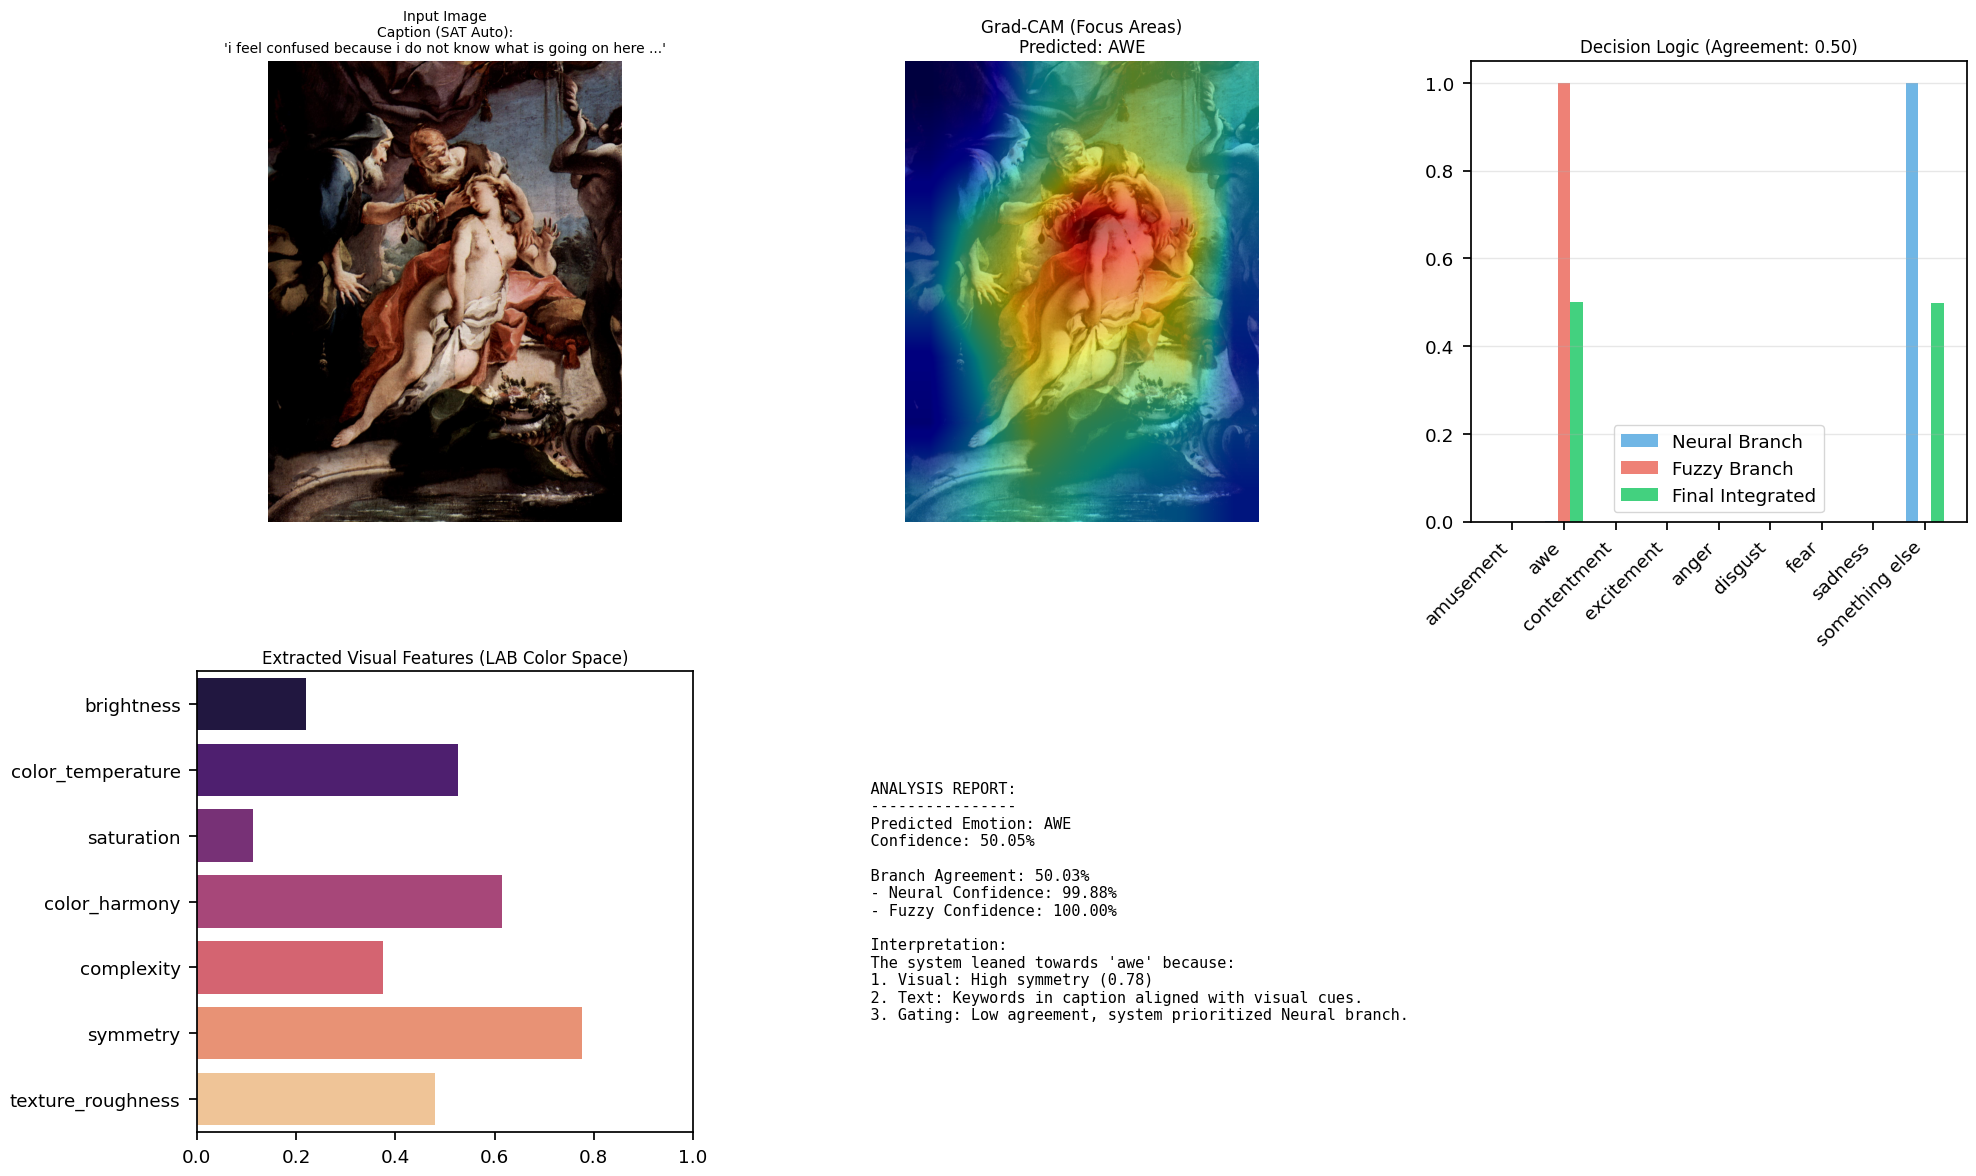


TESTE 2: Análise com SAT (Geração Automática de Legenda)
🎨 Analisando: antoine-watteau_mezzetin-1719.jpg
🤖 Gerando legenda automática (SAT)...
📝 Legenda: 'the woman looks like she is having a good time'


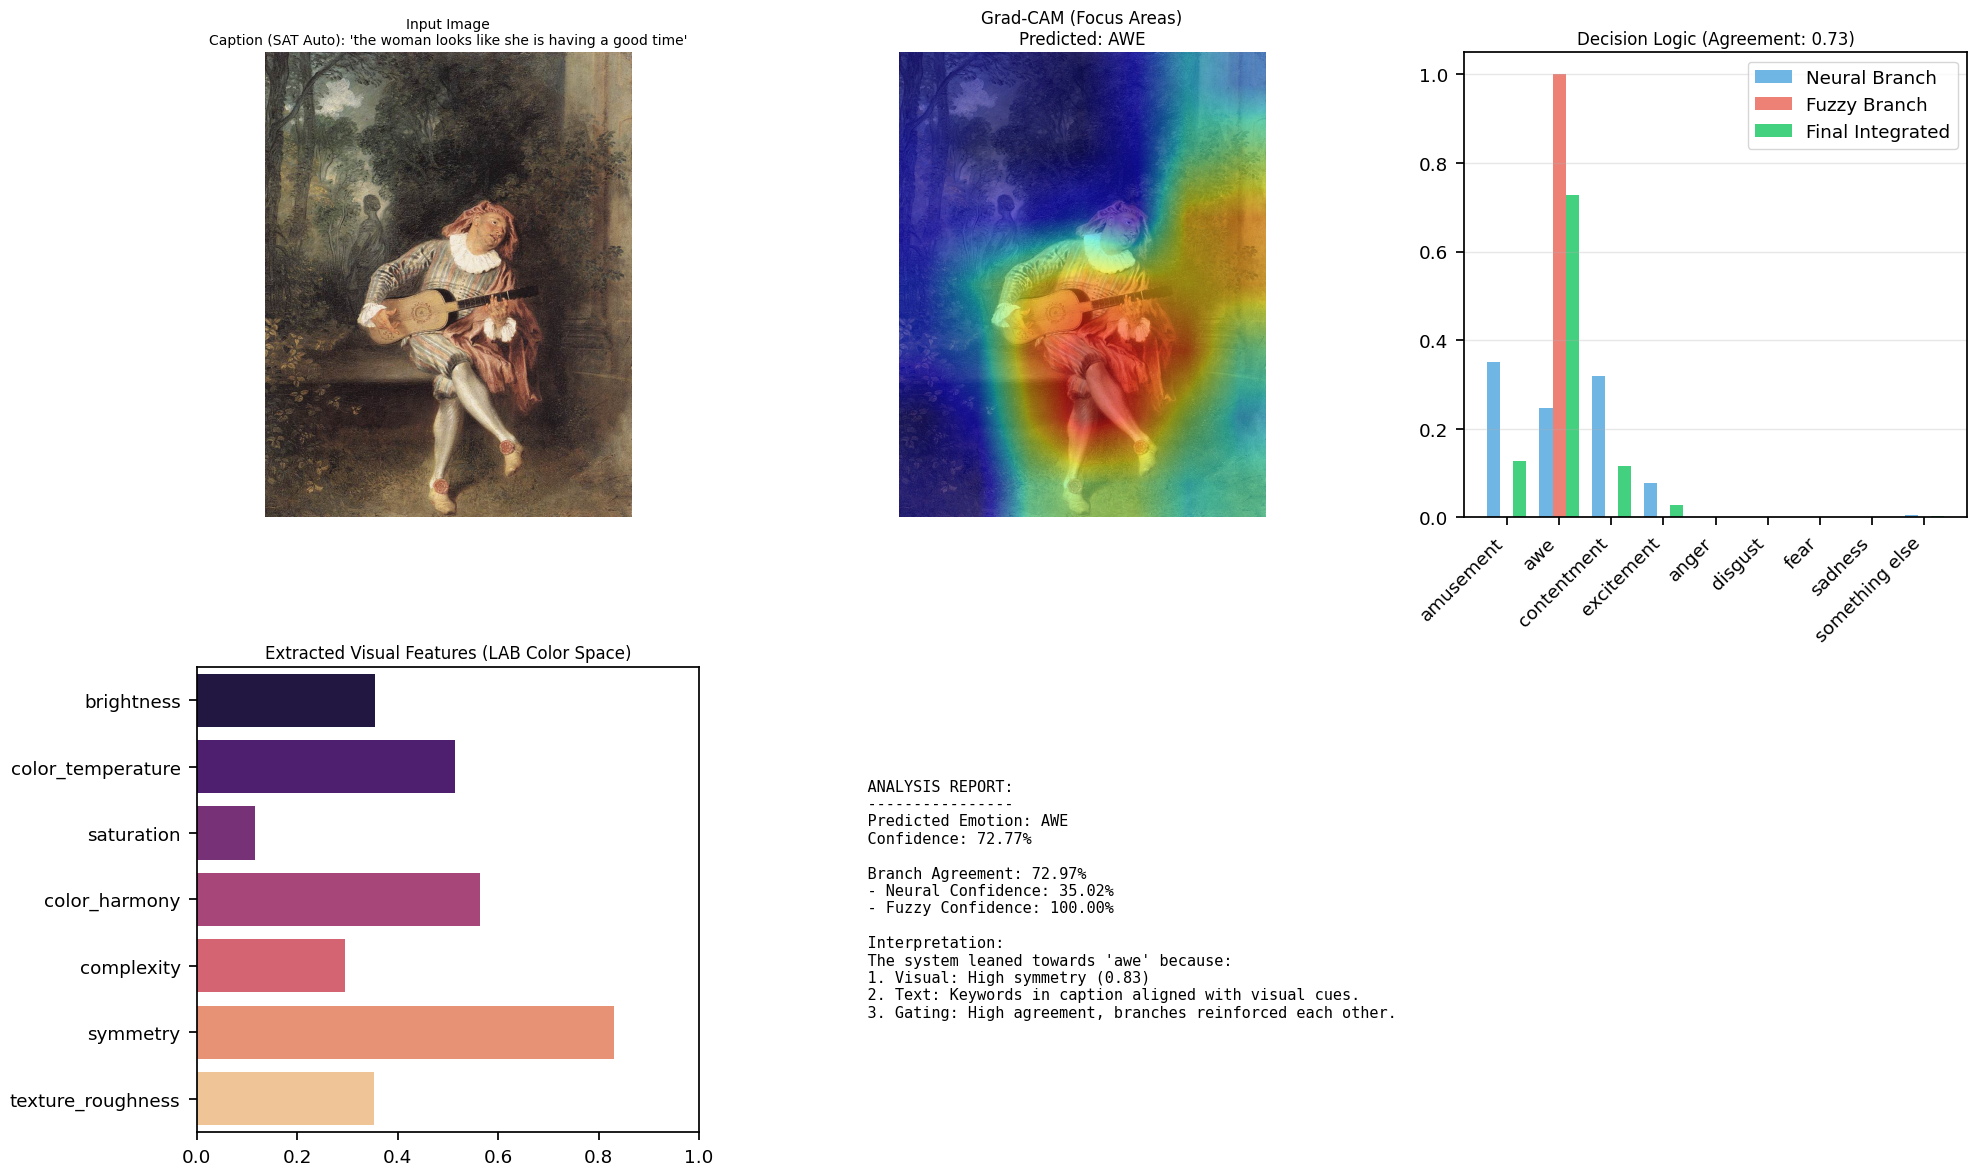

In [17]:
# ============================================================================
# 4. EXECUÇÃO DO DEMO - Pinturas Reais do ArtEmis/WikiArt
# ============================================================================

# Diretório com pinturas organizadas por estilo
ARTEMIS_IMAGES_DIR = Path('/data/paloma/data/paintings/wikiart')

# Seleciona pinturas de diferentes estilos para demonstração
test_paintings = [
    ARTEMIS_IMAGES_DIR / 'Rococo/giovanni-battista-tiepolo_susanna-and-the-elders-1723.jpg',
    ARTEMIS_IMAGES_DIR / 'Rococo/antoine-watteau_mezzetin-1719.jpg',

]

# Verifica quais existem
available_paintings = [p for p in test_paintings if p.exists()]

if not available_paintings:
    print("⚠️ Pinturas específicas não encontradas. Selecionando aleatoriamente...")
    # Busca 3 pinturas aleatórias de diferentes estilos
    import random
    styles = [d for d in ARTEMIS_IMAGES_DIR.iterdir() if d.is_dir()][:5]
    available_paintings = []
    for style in styles:
        imgs = list(style.glob('*.jpg'))
        if imgs:
            available_paintings.append(random.choice(imgs))
        if len(available_paintings) >= 3:
            break

print(f"🎨 Testando com {len(available_paintings)} pinturas reais:")
for p in available_paintings:
    print(f"  - {p.parent.name}/{p.name}")

# DEMO 1: Primeira pintura com SAT (geração automática)
print("\n" + "="*80)
print("TESTE 1: Análise com SAT (Geração Automática de Legenda)")
print("="*80)
analyze_artwork(available_paintings[0], caption=None)

# DEMO 2: Segunda pintura TAMBÉM com SAT (geração automática)
if len(available_paintings) > 1:
    print("\n" + "="*80)
    print("TESTE 2: Análise com SAT (Geração Automática de Legenda)")
    print("="*80)
    
    # Agora TAMBÉM usa SAT para gerar legenda automaticamente
    analyze_artwork(available_paintings[1], caption=None)